# Overview

The goal of this notebook is to find and test different ways of clustering phone screen view data as a preprocessing step before further extraction and classification. The main focus is placed on spacial data.

In [1]:
import numpy as np
import pandas as pd
from typing import Optional
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import json

In [2]:
coupon_df = pd.read_csv('data/18929485529.csv')
coupon_df.head()

,ID,User ID,Time,I,Language,Application Name,Package Name,Class Name,Context,View ID,View Depth,View Class Name,Text,Description,Seen Timestamp,Is Visible,X 1,Y 1,X 2,Y 2
0,18929485529,165559,2024-09-04T10:55:25.287,1,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,0,de.penny.app.main.view.MainActivity,NaN,NaN,0,False,0,0,0,0
1,18929485529,165559,2024-09-04T10:55:25.287,2,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,android:id/content,2,android.widget.FrameLayout,NaN,NaN,1725440082464,True,0,0,1080,2400
2,18929485529,165559,2024-09-04T10:55:25.287,3,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,UVP 14.99,NaN,1725440082464,True,339,833,498,874
3,18929485529,165559,2024-09-04T10:55:25.287,4,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,9.99,NaN,1725440082464,True,356,884,482,960
4,18929485529,165559,2024-09-04T10:55:25.287,5,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,UVP,NaN,1725440082464,True,63,986,125,1027


I define auxiliary functions and modify the data to facilitate further analysis.

In [3]:
class BoundingBox:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = min(x1, x2)
        self.y1 = min(y1, y2)
        self.x2 = max(x1, x2)
        self.y2 = max(y1, y2)

    def __str__(self):
        return f'x1: {self.x1}, y1: {self.y1}, x2: {self.x2}, y2: {self.y2}'

    def intersects(self, other: 'BoundingBox') -> bool:
        if self.x1 >= other.x2 or self.x2 <= other.x1:
            return False

        if self.y1 >= other.y2 or self.y2 <= other.y1:
            return False

        return True

    def merge(self, other: 'BoundingBox') -> 'BoundingBox':
        return BoundingBox(
            min(self.x1, other.x1),
            min(self.y1, other.y1),
            max(self.x2, other.x2),
            max(self.y2, other.y2)
        )

    def intersection(self, other: 'BoundingBox') -> Optional['BoundingBox']:
        if not self.intersects(other):
            return None

        return BoundingBox(
            max(self.x1, other.x1),
            max(self.y1, other.y1),
            min(self.x2, other.x2),
            min(self.y2, other.y2)
        )

    def area(self):
        return (self.x2 - self.x1) * (self.y2 - self.y1)

    def IoU(self, other: 'BoundingBox'):
        if not self.intersects(other):
            return 0

        inter_area = self.intersection(other).area()

        return inter_area / (self.area() + other.area() - inter_area)

    def apply_bias(self, xbias, ybias):
        return BoundingBox(
            self.x1 - xbias,
            self.y1 - ybias,
            self.x2 + xbias,
            self.y2 + ybias
        )

def create_bounding_box(row):
    return BoundingBox(
        row['X 1'],
        row['Y 1'],
        row['X 2'],
        row['Y 2']
    )

coupon_df_mod = coupon_df.copy()
coupon_df_mod['Bounding Box'] = coupon_df_mod.apply(create_bounding_box, axis=1)
coupon_df_mod.drop(columns=['X 1', 'Y 1', 'X 2', 'Y 2'], inplace=True)

I group the data by 'Application Name', since view elements from different applications should not be a part of the same cluster and 'Seen Timestamp', since the bounding box data will be unreliable at different points in time.

In [4]:
grouping_columns = ['Application Name', 'Seen Timestamp']
grouped_coupon_dfs = [group for _, group in coupon_df_mod.groupby(grouping_columns)]

I choose a group of view elements, that will be used to roughly test the clustering algorithms and calculate their distance matrix. The distance that is used here is the inverse of the Jaccard index of bounding boxes, where in the case of no intersection an arbitrarily large value is taken. To address the issue of the lack of intersection between the bounding boxes xbias and ybias are introduced, which will enlarge the bounding boxes in the x and y dimensions respectively. I apply hierarchical clustering with single, average and complete linkage and visualize the results on dendrograms. In the dendrograms, the view elements are indexed relative to their groups.

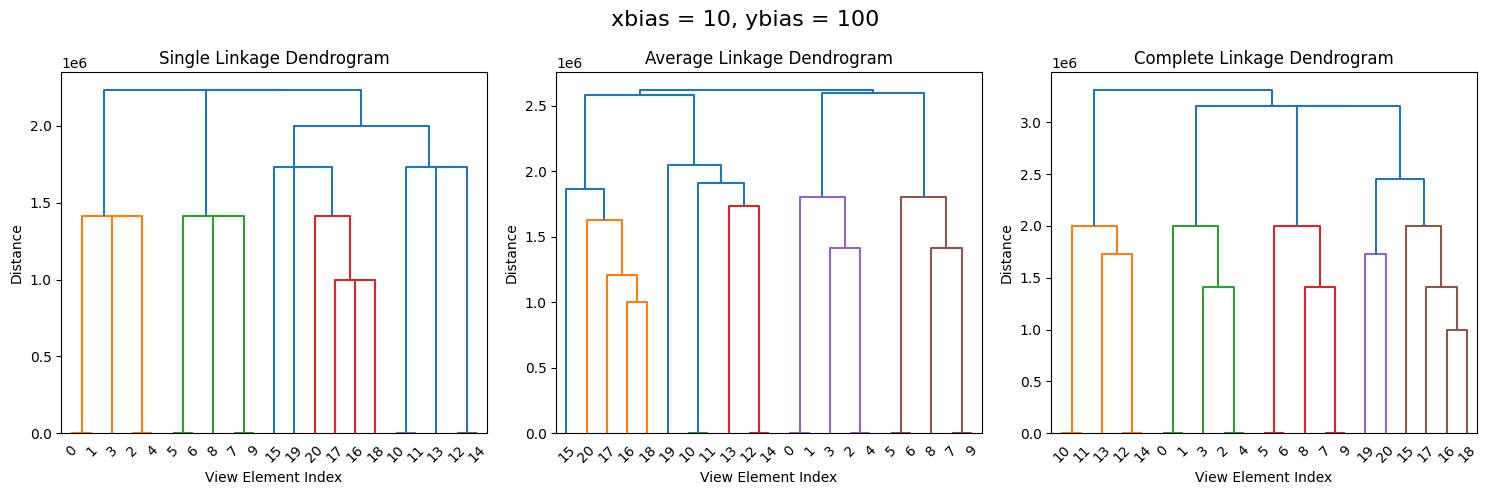

In [5]:
test_df = grouped_coupon_dfs[3]

def calculate_dist_mat(data, xbias, ybias):
    num_rows = data.shape[0]
    dists = np.empty((num_rows, num_rows))

    for i in range(num_rows):
        for j in range(num_rows):
            dists[i, j] = 1 / (data['Bounding Box'].iloc[i].apply_bias(xbias, ybias)
                               .IoU(data['Bounding Box'].iloc[j].apply_bias(xbias, ybias)) + 1e-6)

    return dists

def draw_dendrograms(linkage_single, linkage_average, linkage_complete, plot_group_title=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    if plot_group_title:
        plt.suptitle(plot_group_title, fontsize=16)

    dendrogram(linkage_single, ax=axs[0])
    axs[0].set_title('Single Linkage Dendrogram')
    axs[0].set_xlabel('View Element Index')
    axs[0].set_ylabel('Distance')

    dendrogram(linkage_average, ax=axs[1])
    axs[1].set_title('Average Linkage Dendrogram')
    axs[1].set_xlabel('View Element Index')
    axs[1].set_ylabel('Distance')

    dendrogram(linkage_complete, ax=axs[2])
    axs[2].set_title('Complete Linkage Dendrogram')
    axs[2].set_xlabel('View Element Index')
    axs[2].set_ylabel('Distance')

    plt.tight_layout()
    plt.show()

def cluster_and_draw_dendrograms(data, xbias, ybias):
    distance_matrix = calculate_dist_mat(data=data, xbias=xbias, ybias=ybias)
    linkage_single = linkage(distance_matrix, method='single')
    linkage_average = linkage(distance_matrix, method='average')
    linkage_complete = linkage(distance_matrix, method='complete')
    draw_dendrograms(linkage_single=linkage_single,
                     linkage_average=linkage_average,
                     linkage_complete=linkage_complete,
                     plot_group_title=f'xbias = {xbias}, ybias = {ybias}')
    
cluster_and_draw_dendrograms(data=test_df, xbias=10, ybias=100)

I print the text fields associated with the clustered view elements and the expected output to evaluate the clustering. 

In [6]:
print('Text Fields:')
print(test_df['Text'].reset_index(drop=True))

with open('data/18929485529_expected.json', 'r') as file:
    data = json.load(file)

print()
print('Expected Output:')
print(json.dumps(data, indent=4))

Text Fields:
0                                   UVP 14.99
1                                        9.99
2                                         UVP
3     JOHNNIE WALKER Red Label Blended Scotch
4                                    je 0,7 I
5                                    UVP 0.99
6                                        0.75
7                                         UVP
8                         SAN MIGUEL Especial
9                                    je 0,5 I
10                                   UVP 2.99
11                                       2.79
12                                        UVP
13                          FELIX Knabber Mix
14                                   je 200 g
15                                       3.89
16                               Preisknaller
17      FELIX So gut wie es aussieht in Gelee
18                               je 12 x 85 g
19                                   Framstag
20                       ab 06.09. bis 07.09.
Name: Text, dtype: ob

Comparing the data with the expected output, this seems like a decent first step. It can also be noted that the differences in linkage methods are not significant. The challenges that remain are to find a way of programmatically evaluating the clustering to find proper hyperparameters (xbias and ybias) and find an appropriate distance threshold. Let's examine the outcome of clustering with different hyperparameters.

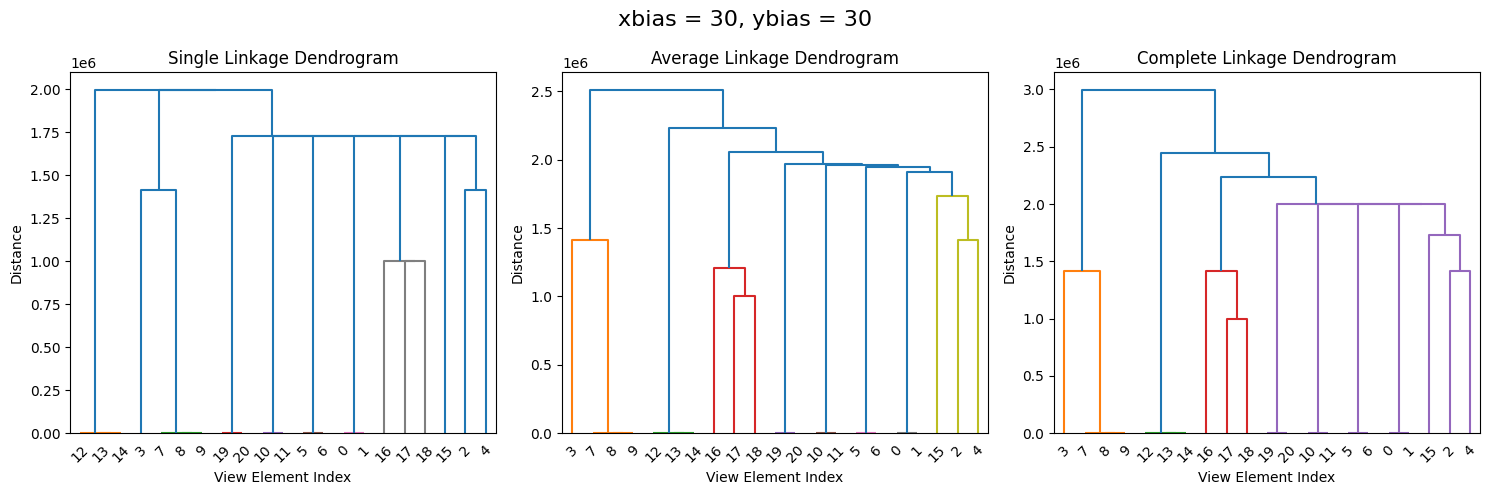

In [7]:
cluster_and_draw_dendrograms(data=test_df, xbias=30, ybias=30)

The choice of xbias and ybias here is noticeably worse. Examination of the dendrograms has prompted me to propose a function defined as such:
$$
\theta(d) = \frac{NC(d) + \Sigma_{i = 1}^{C(d)}c(d, i)^2 - 2N}{N^2 - N}, \text{ for } d \in [0, \infty)
$$
Where, if we take $d$ as the threshold distance, $C(d)$ is the number of clusters, $c(d, i)$ is the size of the $i$-th cluster and $N$ is the size of the dataset. The idea is that we take two functions, $C(d)$ and $\Sigma_{i = 1}^{C(d)}c(d, i)^2$, put them in the range $[0, 1]$ and add them. Finding the minimum of $\theta$ for a given clustering may be useful in evaluating said clustering, as well as, finding the best threshold distance. That is bacause a small value of $\theta$ should, in theory, indicate that we have a relatively small number of clusters and that their sizes are similar (the more uneven the sizes of the clusters, the bigger their sum of squares will be).

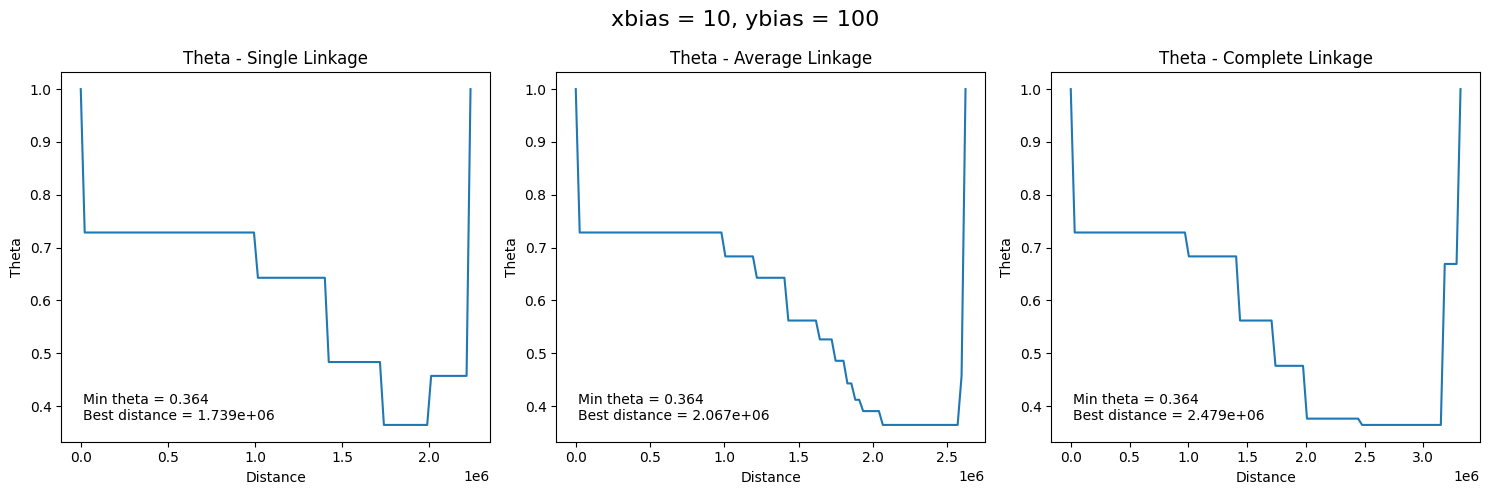

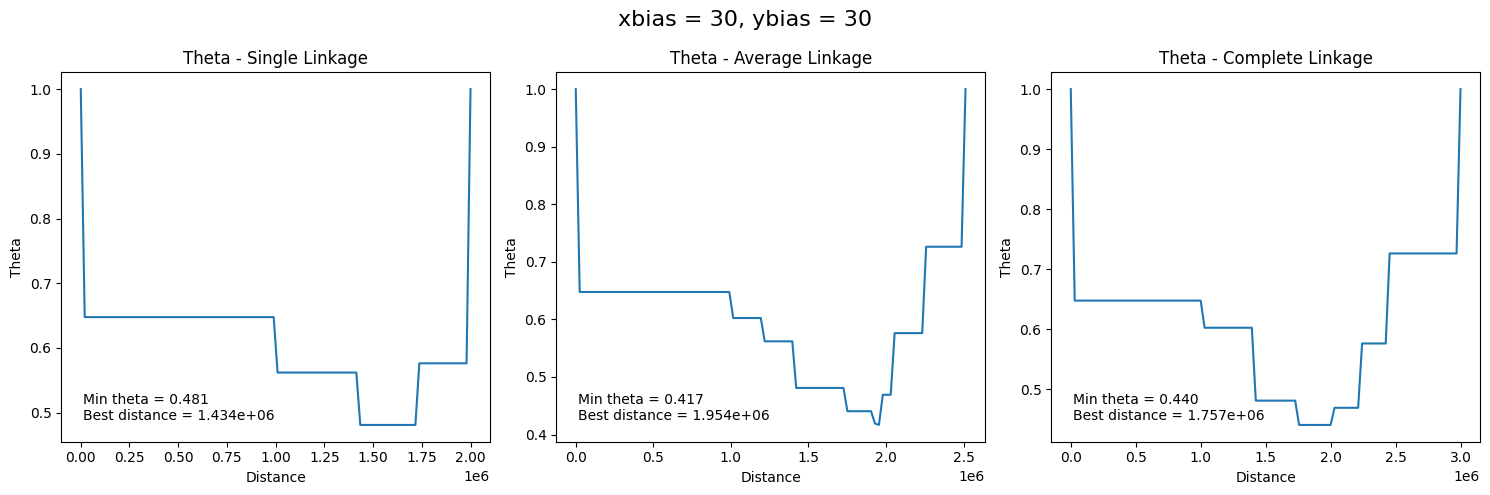

In [8]:
def theta(clusters):
    cluster_sizes = np.bincount(clusters)[1:]
    C = len(cluster_sizes)
    N = np.sum(cluster_sizes)
    sum_sizes_sq = np.sum(cluster_sizes ** 2)
    return ((N * C + sum_sizes_sq - 2 * N) / (N ** 2 - N))

def theta_vs_distance(linkage):
    max_distance = max(linkage[:, 2])
    distances = np.linspace(0, max_distance, 100)
    theta_vals = []
    min_theta = 1
    best_dist = 0

    for d in distances:
        clusters = fcluster(linkage, t=d, criterion='distance')
        theta_val = theta(clusters)
        theta_vals.append(theta_val)
        if theta_val < min_theta:
            min_theta = theta_val
            best_dist = d

    return distances, theta_vals, best_dist, min_theta

def draw_theta(linkage_single, linkage_average, linkage_complete, plot_group_title=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    if plot_group_title:
        plt.suptitle(plot_group_title, fontsize=16)
        
    dists_single, theta_single, best_dist_single, min_theta_single = theta_vs_distance(linkage_single)
    axs[0].plot(dists_single, theta_single)
    axs[0].set_title('Theta - Single Linkage')
    axs[0].set_xlabel('Distance')
    axs[0].set_ylabel('Theta')
    axs[0].text(0.05, 0.05, 
                f'Min theta = {min_theta_single:.3f}\nBest distance = {best_dist_single:.3e}', 
                transform=axs[0].transAxes,
                fontsize=10,
                va='bottom', ha='left')

    dists_average, theta_average, best_dist_average, min_theta_average = theta_vs_distance(linkage_average)
    axs[1].plot(dists_average, theta_average)
    axs[1].set_title('Theta - Average Linkage')
    axs[1].set_xlabel('Distance')
    axs[1].set_ylabel('Theta')
    axs[1].text(0.05, 0.05, 
                f'Min theta = {min_theta_average:.3f}\nBest distance = {best_dist_average:.3e}', 
                transform=axs[1].transAxes,
                fontsize=10,
                va='bottom', ha='left')

    dists_complete, theta_complete, best_dist_complete, min_theta_complete = theta_vs_distance(linkage_complete)
    axs[2].plot(dists_complete, theta_complete)
    axs[2].set_title('Theta - Complete Linkage')
    axs[2].set_xlabel('Distance')
    axs[2].set_ylabel('Theta')
    axs[2].text(0.05, 0.05, 
                f'Min theta = {min_theta_complete:.3f}\nBest distance = {best_dist_complete:.3e}', 
                transform=axs[2].transAxes,
                fontsize=10,
                va='bottom', ha='left')

    plt.tight_layout()
    plt.show()

def cluster_and_draw_theta(data, xbias, ybias):
    distance_matrix = calculate_dist_mat(data=data, xbias=xbias, ybias=ybias)
    linkage_single = linkage(distance_matrix, method='single')
    linkage_average = linkage(distance_matrix, method='average')
    linkage_complete = linkage(distance_matrix, method='complete')
    draw_theta(linkage_single=linkage_single,
               linkage_average=linkage_average,
               linkage_complete=linkage_complete,
               plot_group_title=f'xbias = {xbias}, ybias = {ybias}')

cluster_and_draw_theta(data=test_df, xbias=10, ybias=100)
cluster_and_draw_theta(data=test_df, xbias=30, ybias=30)

As can be seen, the minimum of $\theta$ (which will be called $\theta$-score from now on) for the better clusterings tends to be smaller than the one for the poorer ones. The difference is the most noticable in the case of single linkage. With an established method for evaluating clustering quality, we may now perform a grid search to find optimal hyperparameters.

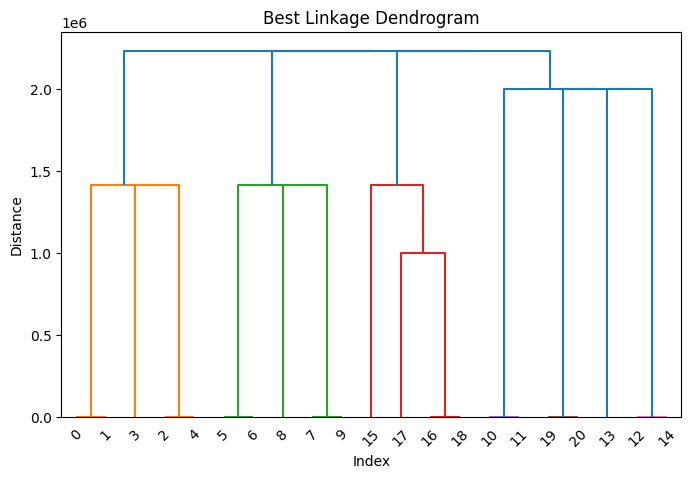

Theta score = 0.374
Distance threshold = 2.010e+06
Best xbias = 0.000
Best ybias = 133.333


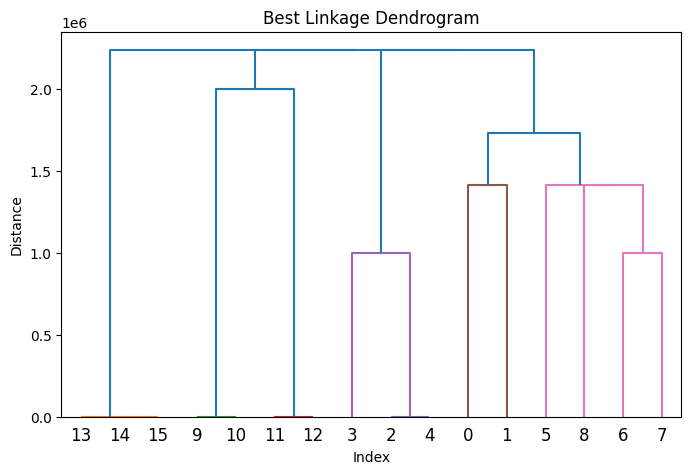

Theta score = 0.425
Distance threshold = 2.010e+06
Best xbias = 66.667
Best ybias = 66.667


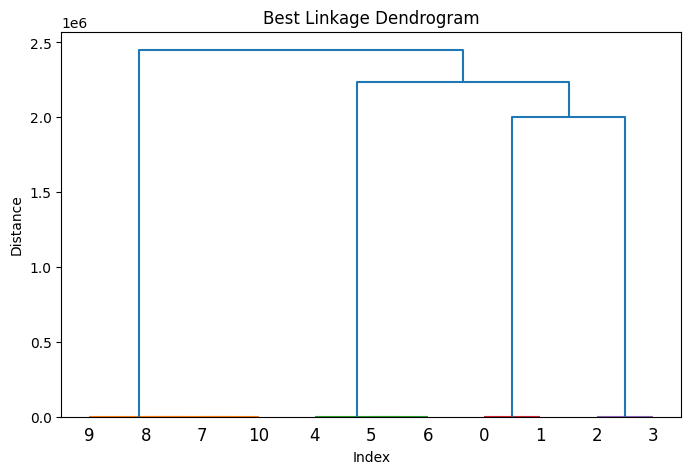

Theta score = 0.473
Distance threshold = 2.004e+06
Best xbias = 233.333
Best ybias = 33.333


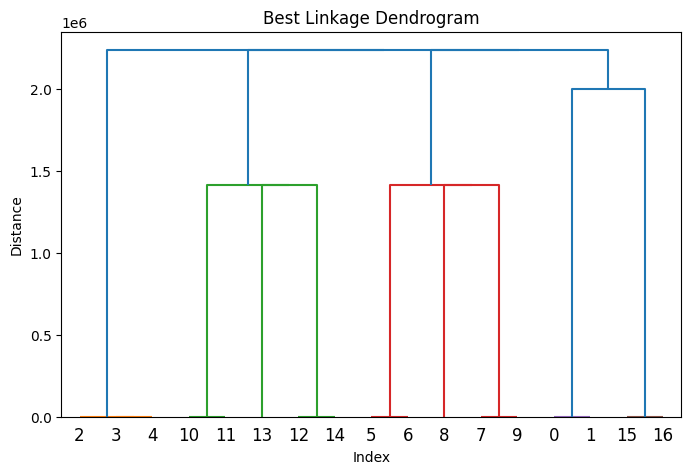

Theta score = 0.401
Distance threshold = 2.010e+06
Best xbias = 0.000
Best ybias = 100.000


In [9]:
def grid_search(data, xbiases, ybiases, linkage_method):
    min_theta = 1
    best_dist = 0
    best_xbias = 0
    best_ybias = 0
    best_linkage = None
    for xbias in xbiases:
        for ybias in ybiases:
            distance_matrix = calculate_dist_mat(data=data, xbias=xbias, ybias=ybias)
            link = linkage(distance_matrix, method=linkage_method)
            _, _, best_dist_aux, min_theta_aux = theta_vs_distance(link)
            
            if min_theta_aux < min_theta:
                min_theta = min_theta_aux
                best_dist = best_dist_aux
                best_xbias = xbias
                best_ybias = ybias
                best_linkage = link

    plt.figure(figsize=(8, 5))
    dendrogram(best_linkage)
    plt.title('Best Linkage Dendrogram')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.show()
    print(f'Theta score = {min_theta:.3f}')
    print(f'Distance threshold = {best_dist:.3e}')
    print(f'Best xbias = {best_xbias:.3f}')
    print(f'Best ybias = {best_ybias:.3f}')

grid_search(data=grouped_coupon_dfs[3], xbiases=np.linspace(0, 300, 10), ybiases=np.linspace(0, 300, 10), linkage_method='single')
grid_search(data=grouped_coupon_dfs[4], xbiases=np.linspace(0, 300, 10), ybiases=np.linspace(0, 300, 10), linkage_method='single')
grid_search(data=grouped_coupon_dfs[5], xbiases=np.linspace(0, 300, 10), ybiases=np.linspace(0, 300, 10), linkage_method='single')
grid_search(data=grouped_coupon_dfs[6], xbiases=np.linspace(0, 300, 10), ybiases=np.linspace(0, 300, 10), linkage_method='single')

The results vary in quality. Further experiments are needed to establish the relationship between the $\theta$-score and the size of the dataset, as well as, the effectiveness of the proposed algorithm on other datasets.